In [1]:
#pip install qiskit qiskit_aer pylatexenc

In [2]:
from qiskit.circuit.library import StatePreparation
from qiskit.circuit import ControlledGate
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, AncillaRegister
from qiskit.quantum_info import Statevector

from qiskit_aer import AerSimulator
from qiskit import transpile

In [3]:
def prepare_state_generic(state_dict, num_of_qubits):
    coefficients = [state_dict.get(format(i, '0' + str(num_of_qubits) + 'b'), 0) for i in range(2**num_of_qubits)]
    state = StatePreparation(coefficients)
    return state

def prepare_circuit_initial_state(value, probability):
    zero_state_dict = {
        '00000': 1/4,
        '10010': 1/4,
        '01001': 1/4,
        '10100': 1/4,
        '01010': 1/4,
        '11011': -1/4,
        '00110': -1/4,
        '11000': -1/4,
        '11101': -1/4,
        '00011': -1/4,
        '11110': -1/4,
        '01111': -1/4,
        '10001': -1/4,
        '01100': -1/4,
        '10111': -1/4,
        '00101': 1/4
    }

    one_state_dict = {
        '11111': 1/4,
        '01101': 1/4,
        '10110': 1/4,
        '01011': 1/4,
        '10101': 1/4,
        '00100': -1/4,
        '11001': -1/4,
        '00111': -1/4,
        '00010': -1/4,
        '11100': -1/4,
        '00001': -1/4,
        '10000': -1/4,
        '01110': -1/4,
        '10011': -1/4,
        '01000': -1/4,
        '11010': 1/4
    }

    initial_state = None
    if value == True:
        initial_state = one_state_dict
    else:
        initial_state = zero_state_dict

    # Prepare state according to the input 
    state_preparation = prepare_state_generic(initial_state, 5)

    return state_preparation

In [4]:
def five_qubit_error_code_circuit(value, probability):
    qc = QuantumCircuit()
    ancillas = AncillaRegister(size = 4)
    qubits = QuantumRegister(size = 5)
    qc.add_register(ancillas)
    qc.add_register(qubits)

    state_preparation = prepare_circuit_initial_state(value, probability)
    qc.append(state_preparation, range(4,9))
    qc.x(5) #just for testing purposes

    qc.h(0)
    qc.h(1)
    qc.h(2)
    qc.h(3)

    qc.cx(0, 4)
    qc.cz(1, 5, 'Z')

    qc.cz(0, 6, 'Z')
    qc.cx(1, 5)
    qc.cx(2, 4)

    qc.cx(7, 0)
    qc.cz(6, 1, 'Z')
    qc.cz(3, 4, 'Z')

    qc.cz(1, 7, 'Z')
    qc.cx(2, 6)
    qc.cx(3, 5)

    qc.cx(1, 8)
    qc.cz(2, 7, 'Z')

    qc.cz(2, 8, 'Z')
    qc.cx(3, 7)

    qc.cz(3, 8)

    qc.barrier()

    qc.h(0)
    qc.h(1)
    qc.h(2)
    qc.h(3)    

    # Measure ancillas to check what we need to correct
    error_correction(qc, ancillas)

    return qc

In [5]:
def error_correction(circuit, ancillas):
    syndromes = ClassicalRegister(4, name="syndromes")
    circuit.add_register(syndromes)
    circuit.measure(ancillas, syndromes)

    with circuit.switch(syndromes) as case:
        with case(0b0001):
            circuit.x(0)
        with case(0b1000):
            circuit.x(1)
        with case(0b1100):
            circuit.x(2)
        with case(0b0110):
            circuit.x(3)
        with case(0b0011):
            circuit.x(4)
        with case(0b1010):
            circuit.z(0)
        with case(0b0101):
            circuit.z(1)
        with case(0b0010):
            circuit.z(2)
        with case(0b1001):
            circuit.z(3)
        with case(0b0100):
            circuit.z(4)
        with case(0b1011):
            circuit.y(0)
        with case(0b1101):
            circuit.y(1)
        with case(0b1110):
            circuit.y(2)
        with case(0b1111):
            circuit.y(3)
        with case(0b0111):
            circuit.y(4)
            

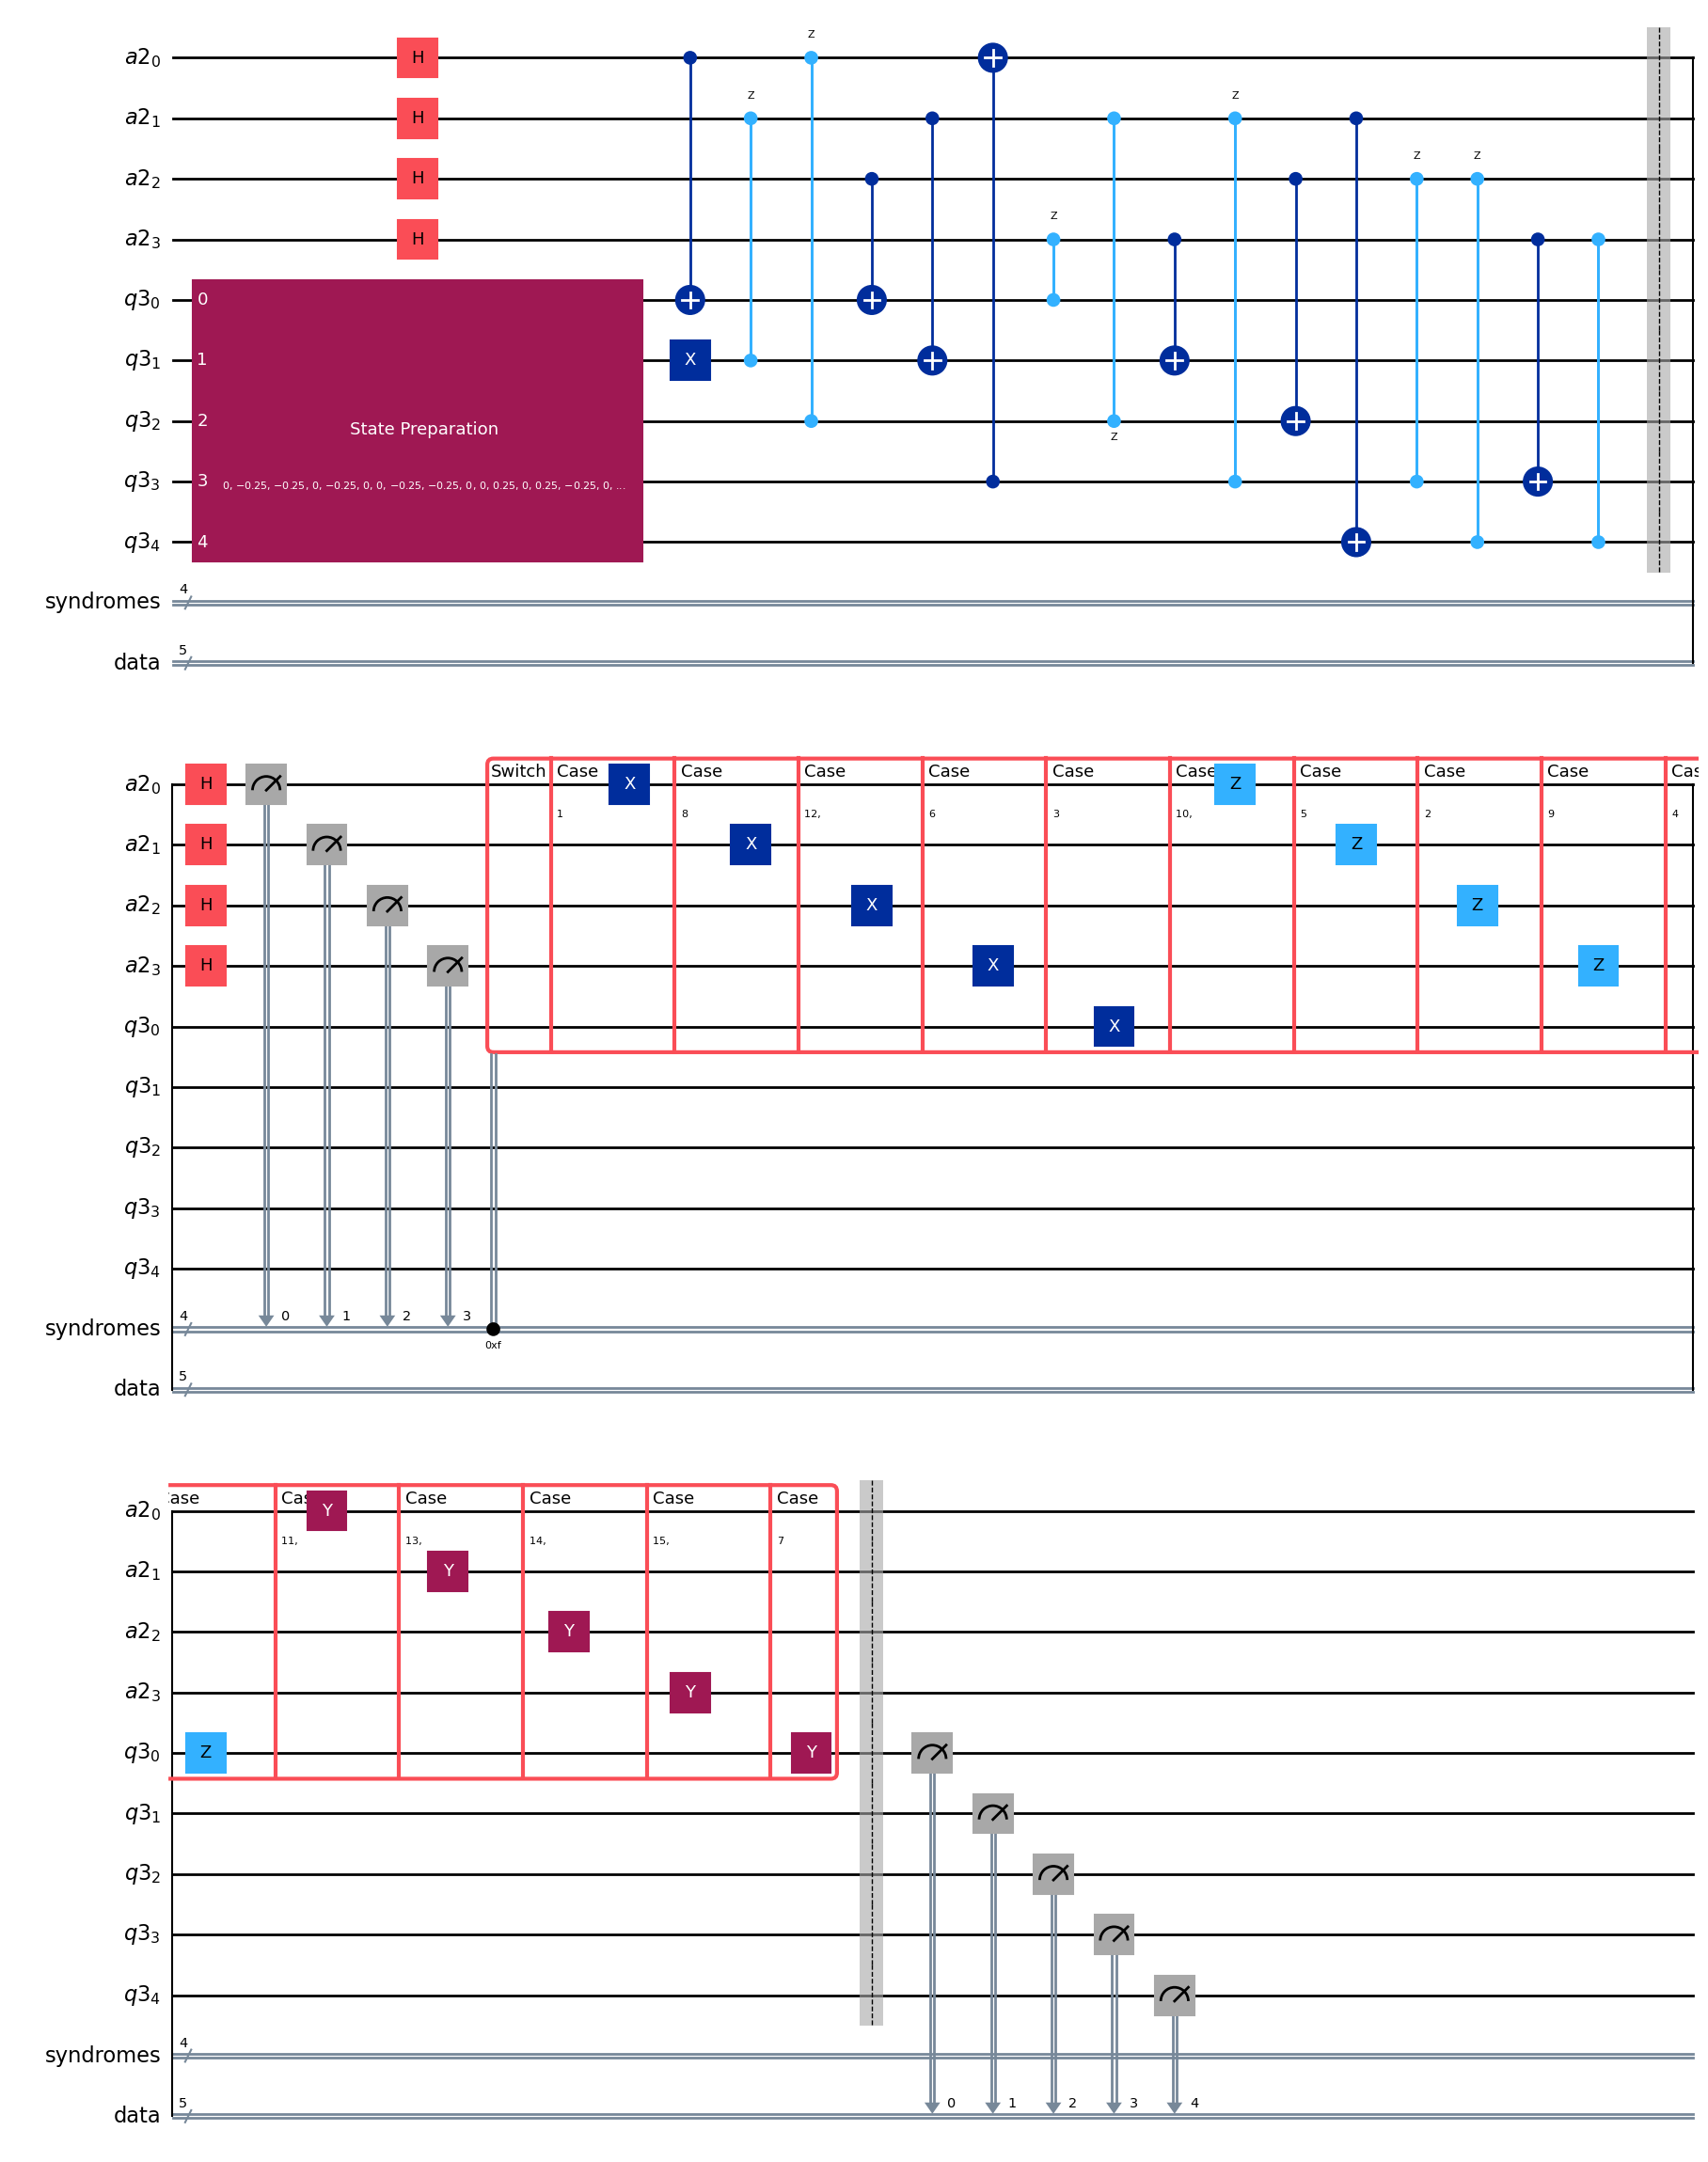

In [10]:
# Create the circuit for the five-qubit error correction code
# The initial state is set to True (1) with a probability of 1
# test the circuit with a specific initial state, remember that in the circuit we applied X gate to the 5th qubit
# so the initial state is actually 10000, an error
circuit = five_qubit_error_code_circuit(True, 1)

classical_register_for_data = ClassicalRegister(5, name="data")
circuit.add_register(classical_register_for_data)
circuit.barrier()

# measure
circuit.measure(range(4,9), classical_register_for_data)

circuit.draw(output="mpl")

In [ ]:
# Create a simulator backend and run the circuit to test if it works correctly
simulator = AerSimulator()

# Transpile the circuit for the backend
compiled_circuit = transpile(circuit, simulator)

# Run the circuit
job = simulator.run(compiled_circuit, shots=100)

# Get the measurement counts
counts = job.result().get_counts()

counts

{'11011 0010': 1,
 '01000 1101': 1,
 '11101 0010': 1,
 '01110 1100': 1,
 '01101 1100': 1,
 '10011 1100': 1,
 '01100 0010': 1,
 '11111 0011': 1,
 '10011 0101': 1,
 '00111 0011': 1,
 '01010 1010': 1,
 '10100 0000': 1,
 '10111 0010': 1,
 '00001 0100': 1,
 '01011 0101': 1,
 '10000 0100': 1,
 '11100 1101': 1,
 '11001 1100': 1,
 '01000 0100': 1,
 '01101 0110': 1,
 '00110 1001': 1,
 '10110 0100': 1,
 '10101 1110': 1,
 '10000 0101': 1,
 '00011 1011': 2,
 '10100 0111': 1,
 '10010 1000': 1,
 '10110 1110': 1,
 '11111 1100': 1,
 '11110 0010': 2,
 '01010 0010': 1,
 '10101 0110': 1,
 '11100 1111': 1,
 '01110 1101': 1,
 '11000 0010': 3,
 '01100 1010': 1,
 '00010 0110': 2,
 '11010 0100': 2,
 '11000 0111': 1,
 '11111 0101': 2,
 '01001 0000': 1,
 '00111 0110': 1,
 '01010 0001': 2,
 '01110 0101': 1,
 '01111 0000': 1,
 '11000 1000': 1,
 '01100 1000': 1,
 '11100 0100': 1,
 '00100 1100': 1,
 '00100 1110': 2,
 '00010 1110': 1,
 '01010 1011': 1,
 '00100 0100': 1,
 '11110 1010': 4,
 '00110 0000': 1,
 '11111 11